In [517]:
from run_experiment import Experiment
from radar_plots import RadarPlot
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model, single_mtd_simulation, mtd_ai_simulation, multiple_mtd_simulation, specific_multiple_mtd_simulation
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from stacked_plots import StackedBarChart
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [518]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 15000
network_size = [150]
total_nodes = 150
new_network = True

trial = 500


mtd_strategies = [
    CompleteTopologyShuffle,
    # HostTopologyShuffle,
    IPShuffle,
    OSDiversity,
    # PortShuffle,
    # OSDiversityAssignment,
    ServiceDiversity,
    # UserShuffle
]
result_head_path = '/Users/williamho/Documents/GitHub/MTDSim'
mtd_intervals = [100,200]

In [519]:
static_features = ["host_compromise_ratio", "attack_path_exposure",  "overall_asr_avg", "roa",  "risk"]
time_features = ["mtd_freq", "overall_mttc_avg", "time_since_last_mtd"]
metrics = ["all_features"] + ['hybrid'] + static_features + time_features 

# Data Processing

In [520]:
all_model_data = pd.DataFrame()
for mtd_interval in mtd_intervals:
    # Create an empty DataFrame to store all the data for all metrics
    all_model_data_set = pd.DataFrame()

    for metric in metrics:
        models = [
        
            f"{metric}_CompleteTopologyShuffle",
            f"{metric}_IPShuffle",
        
            f"{metric}_OSDiversity",
            f"{metric}_ServiceDiversity",
            metric,
        ]
        
            
        # Initialize the chart for the current model
        chart = StackedBarChart(metric, epsilon, start_time, finish_time, mtd_interval, network_size, total_nodes, new_network, "overview", trial, result_head_path)
        weights = {'ASR': 1, 'time_to_compromise': 1, 'attack_path_exposure': 1, "ROA": 1, "risk": 1}  # Custom weights
        
        # Get data for current model
        schemes_data = pd.DataFrame(chart.multiple_scaled_pipeline(models, run_trial=False))


        
        
        # Concatenate the current schemes_data to all_model_data along the columns (axis=1)
        if all_model_data_set.empty:
            all_model_data_set = schemes_data
        else:
            all_model_data_set = pd.concat([all_model_data_set, schemes_data], axis=1)

    all_model_data = pd.concat([all_model_data, all_model_data_set], axis=1)



In [521]:
all_model_data = all_model_data.T[[ "ROA", "risk", "ASR", "attack_path_exposure","mtd_interval"]]
all_model_data['sum'] = all_model_data[[  "ASR","attack_path_exposure","ROA", "risk",]].sum(axis=1)

In [522]:
all_model_data

,ROA,risk,ASR,attack_path_exposure,mtd_interval,sum
all_features_CompleteTopologyShuffle,1.217108,1.140726,1.517635,2.214429,100.0,6.089897
all_features_IPShuffle,1.035258,1.004456,1.715332,1.636136,100.0,5.391183
all_features_OSDiversity,1.505303,1.344371,3.626216,2.482523,100.0,8.958413
all_features_ServiceDiversity,1.230474,1.158408,3.408932,2.345602,100.0,8.143417
all_features,1.152683,1.123573,2.086719,2.303309,100.0,6.666283
...,...,...,...,...,...,...
time_since_last_mtd_CompleteTopologyShuffle,1.246372,1.179879,1.508145,2.211664,200.0,6.146060
time_since_last_mtd_IPShuffle,1.002880,1.005583,1.663715,1.722391,200.0,5.394569
time_since_last_mtd_OSDiversity,1.317353,1.169323,1.555809,2.659974,200.0,6.702459
time_since_last_mtd_ServiceDiversity,1.213557,1.074634,1.539686,2.589975,200.0,6.417852


In [523]:
data = {}

In [524]:
def get_metrics_set(data):
    sets = {}
    mtd_schemes = [
        "CompleteTopologyShuffle",
        "IPShuffle",
        "OSDiversity",
        "ServiceDiversity",
        "AnyMTD"
    ]

    # Create a combined regex pattern for the MTD schemes
    mtd_regex = '|'.join(mtd_schemes)

    # Loop through the MTD schemes and filter matching columns
    for mtd in mtd_schemes:
        metric_data = data.filter(regex=mtd)  # Filter columns matching the MTD scheme
        sets[mtd] = metric_data  # Store filtered data in sets dictionary with MTD scheme as key

    # Filter the columns that do NOT match any of the MTD schemes
    # Filter the columns that contain any of the MTD schemes
    excluded_data = data.filter(regex=f'^(?!.*({mtd_regex})).*', axis=1)

    # Add suffix '_all_mtd' to all columns in the excluded_data DataFrame
    excluded_data = excluded_data.rename(columns=lambda x: f"{x}_AnyMTD")
    # Store the excluded data (non-MTD scheme columns) in the sets dictionary
    sets['AnyMTD'] = excluded_data

    return sets

In [525]:
for mtd_interval in mtd_intervals:
    interval_data = all_model_data[all_model_data['mtd_interval'] == mtd_interval].T
    data[f"mtd_interval_{mtd_interval}"] = get_metrics_set(interval_data)

In [526]:
data['mtd_interval_100']["AnyMTD"]

,all_features_AnyMTD,hybrid_AnyMTD,host_compromise_ratio_AnyMTD,attack_path_exposure_AnyMTD,overall_asr_avg_AnyMTD,roa_AnyMTD,risk_AnyMTD,mtd_freq_AnyMTD,overall_mttc_avg_AnyMTD,time_since_last_mtd_AnyMTD
ROA,1.152683,1.254755,1.258836,1.308524,1.374935,1.264310,1.281550,1.280759,1.312882,1.405845
risk,1.123573,1.144433,1.160357,1.177332,1.225550,1.158631,1.144601,1.111862,1.229391,1.261219
ASR,2.086719,2.124949,2.112107,2.131274,2.129082,2.122435,2.115989,2.117749,2.109839,2.115854
attack_path_exposure,2.303309,2.276588,2.307598,2.290591,2.301004,2.297721,2.343311,2.292369,2.289703,2.318990
mtd_interval,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
sum,6.666283,6.800725,6.838898,6.907720,7.030572,6.843097,6.885451,6.802740,6.941814,7.101908


# Data Visualization

In [527]:
data['mtd_interval_100']

{'CompleteTopologyShuffle':                       all_features_CompleteTopologyShuffle  \
 ROA                                               1.217108   
 risk                                              1.140726   
 ASR                                               1.517635   
 attack_path_exposure                              2.214429   
 mtd_interval                                    100.000000   
 sum                                               6.089897   
 
                       hybrid_CompleteTopologyShuffle  \
 ROA                                         1.237485   
 risk                                        1.164875   
 ASR                                         1.506355   
 attack_path_exposure                        2.236797   
 mtd_interval                              100.000000   
 sum                                         6.145512   
 
                       host_compromise_ratio_CompleteTopologyShuffle  \
 ROA                                                     

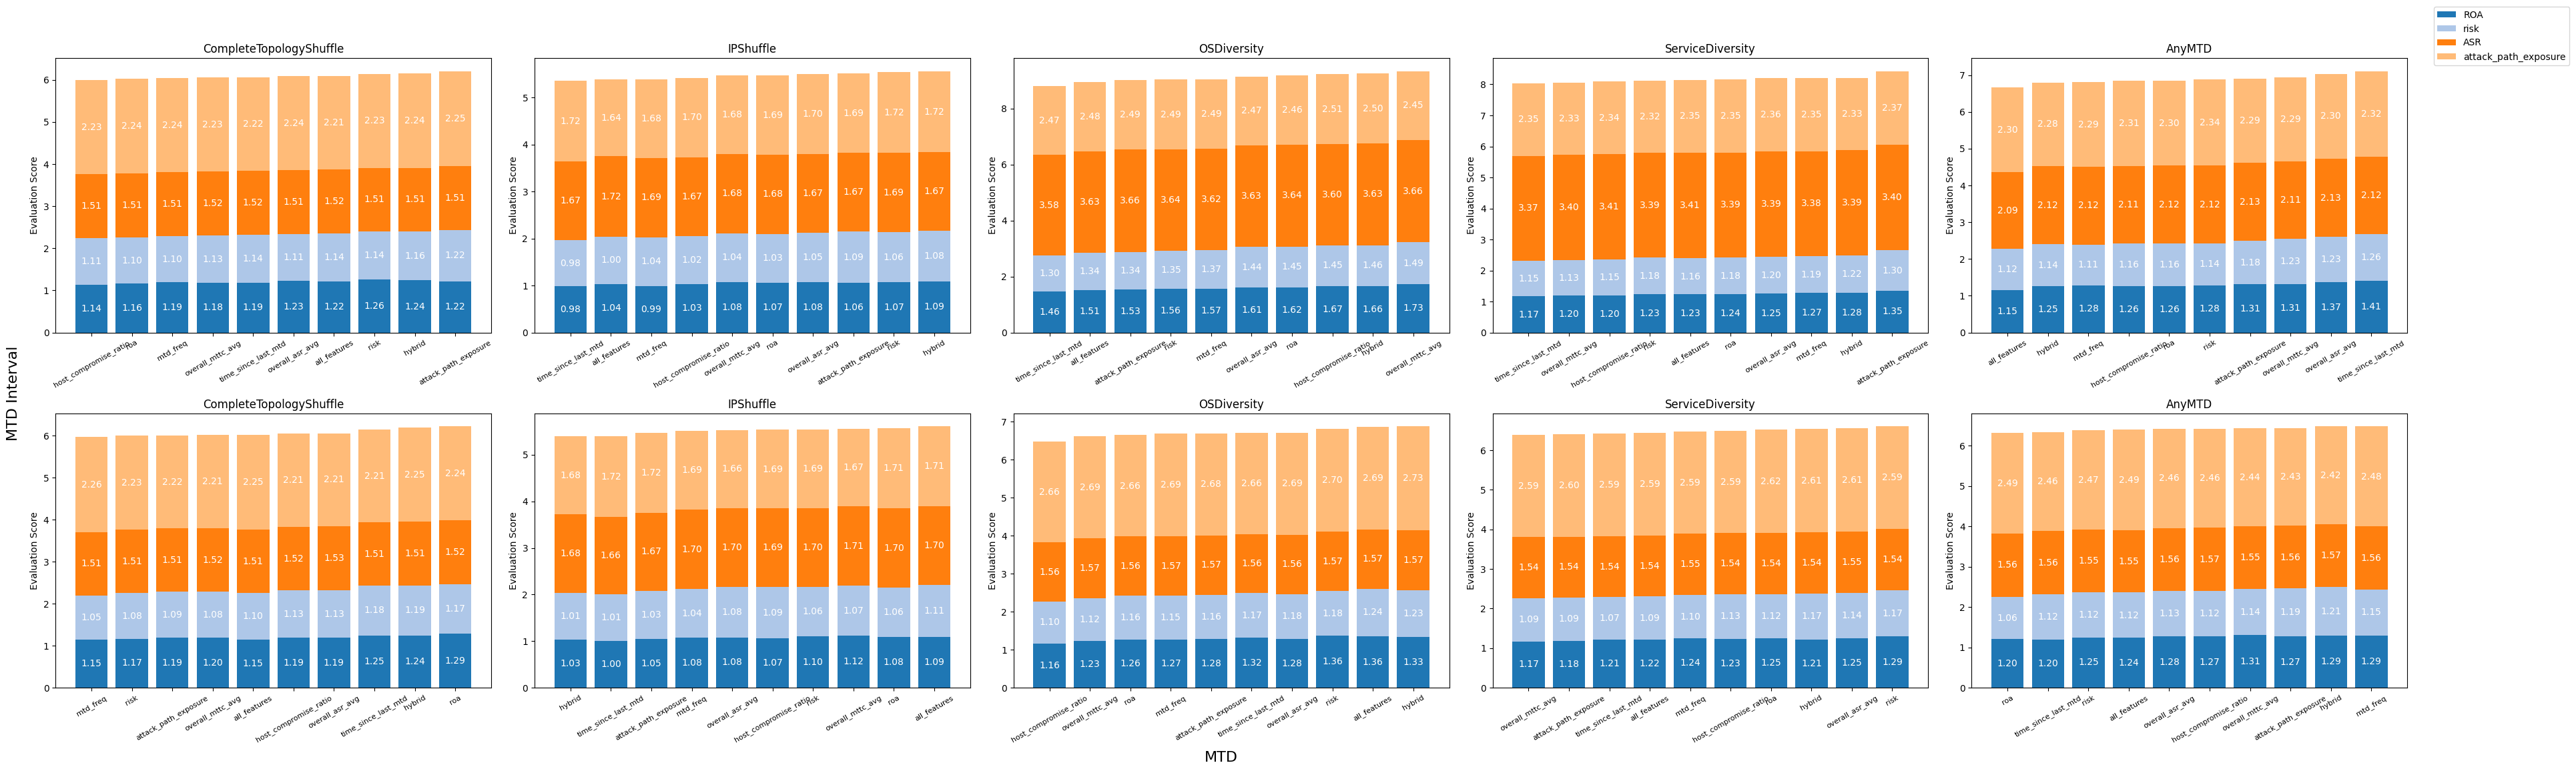

In [528]:
import matplotlib.pyplot as plt
import numpy as np

num_rows = 2
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 12))  # Larger figsize for better visibility

# Initialize a subplot index
subplot_idx = 0

# Iterate over each mtd_interval to create a stacked bar plot
for mtd_interval in mtd_intervals:
    # Iterate through the mtd data
    for mtd in data[f'mtd_interval_{mtd_interval}']:
        # Calculate the current row and column index for the subplot
        row = subplot_idx // num_cols
        col = subplot_idx % num_cols
        
        # Check to avoid out-of-bounds error
        if row < num_rows:
            data_copy = data[f'mtd_interval_{mtd_interval}'][mtd].drop("mtd_interval", axis=0)

            mtd_data = data_copy.filter(regex=mtd).T.sort_values(by='sum').T
            mtd_data = mtd_data.drop(["sum"]).T  # Filter data for the current mtd

            # Extract MTD names and values for plotting
            mtd_names = mtd_data.columns  # Extract MTD names
            values = mtd_data.values  # Extract values to plot

            # Create a stacked bar plot
            bottom = np.zeros(len(mtd_data))  # Initialize bottom to stack bars
            colors = plt.cm.tab20.colors  # Get colors for each MTD
            
            for i, mtd_name in enumerate(mtd_names):
                bars = axes[row, col].bar(mtd_data.index, values[:, i], 
                                           label=mtd_name, color=colors[i % len(colors)], bottom=bottom)
                
                # Annotate the bars with the value
                for j, bar in enumerate(bars):
                    height = bar.get_height()
                    axes[row, col].text(bar.get_x() + bar.get_width() / 2., bottom[j] + height / 2, 
                                        f'{height:.2f}', ha='center', va='center', fontsize=10, color='white')
                
                bottom += values[:, i]  # Update bottom for stacking

            # Add labels and title for each subplot
            axes[row, col].set_ylabel('Evaluation Score', fontsize=10)
            axes[row, col].set_title(f'{mtd}', fontsize=12)

            # Rotate the x-axis labels by 30 degrees for better readability
            axes[row, col].tick_params(axis='x', rotation=30)

            # Modify x-tick labels: Remove the last part after the last underscore
            modified_labels = ['_'.join(label.split('_')[:-1]) for label in mtd_data.index]
            axes[row, col].set_xticklabels(modified_labels, fontsize=8)  # Set smaller font size for x-axis labels
            
            # Increment the subplot index
            subplot_idx += 1

# Add overall x-label and y-label
fig.text(0.5, 0.04, 'MTD', ha='center', fontsize=16)  # X-axis label
fig.text(0.045, 0.5, 'MTD Interval', va='center', rotation='vertical', fontsize=16)  # Y-axis label

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust layout to make room for labels

# Add the legend outside of the graphs
plt.legend( bbox_to_anchor=(1.05, 2.5), loc='upper left', fontsize=10)

plt.show()


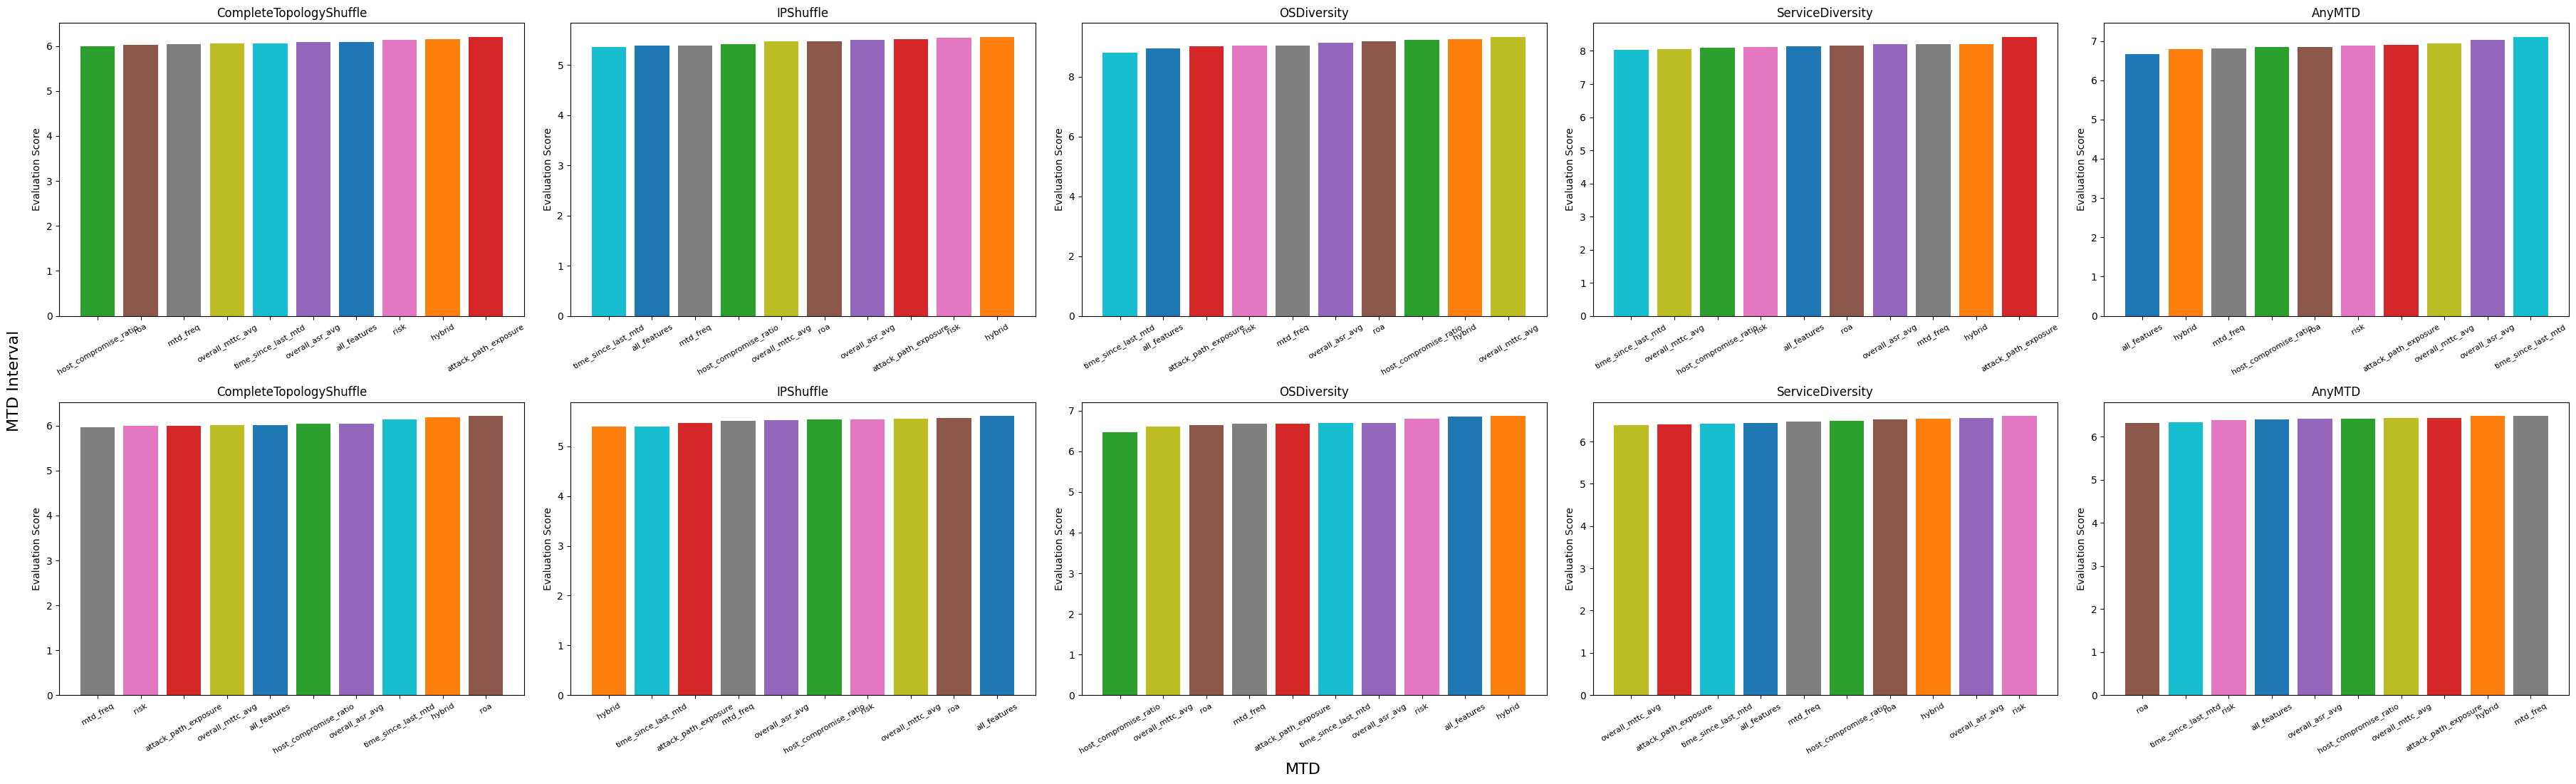

In [575]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D  # Import Line2D for custom legend handles

# Define a color mapping for the metrics
color_mapping = {
    "all_features": "#1f77b4",       # Blue
    "hybrid": "#ff7f0e",             # Orange
    "host_compromise_ratio": "#2ca02c",  # Green
    "attack_path_exposure": "#d62728",   # Red
    "overall_asr_avg": "#9467bd",         # Purple
    "roa": "#8c564b",                    # Brown
    "risk": "#e377c2",                   # Pink
    "mtd_freq": "#7f7f7f",               # Grey
    "overall_mttc_avg": "#bcbd22",      # Yellow-Green
    "time_since_last_mtd": "#17becf"     # Cyan
}

num_rows = 2
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 12))  # Larger figsize for better visibility

# Initialize a subplot index
subplot_idx = 0

# Iterate over each mtd_interval to create a stacked bar plot
for mtd_interval in mtd_intervals:
    # Iterate through the mtd data
    for mtd in data[f'mtd_interval_{mtd_interval}']:
        # Calculate the current row and column index for the subplot
        row = subplot_idx // num_cols
        col = subplot_idx % num_cols
        
        # Check to avoid out-of-bounds error
        if row < num_rows:
            data_copy = data[f'mtd_interval_{mtd_interval}'][mtd].drop("mtd_interval", axis=0)

            mtd_data = data_copy.filter(regex=mtd).T.sort_values(by='sum').T
            mtd_data = mtd_data.T['sum'].T  # Filter data for the current mtd
            
            # Modify x-tick labels: Remove the last part after the last underscore
            modified_labels = ['_'.join(label.split('_')[:-1]) for label in mtd_data.index]
            colors = [color_mapping[label] for label in modified_labels if label in color_mapping]

            # Extract values to plot
            values = mtd_data.values  # Extract values to plot
            
            # Create the bar plot
            bars = axes[row, col].bar(modified_labels, values, color=colors)

            # Add labels and title for each subplot
            axes[row, col].set_ylabel('Evaluation Score', fontsize=10)
            axes[row, col].set_title(f'{mtd}', fontsize=12)

            # Rotate the x-axis labels by 30 degrees for better readability
            axes[row, col].tick_params(axis='x', rotation=30)

            # Set x-tick labels with a smaller font size
            axes[row, col].set_xticklabels(modified_labels, fontsize=8)

            # Prepare the legend handles
            unique_modified_labels = list(dict.fromkeys(modified_labels))  # Keeps the order and removes duplicates
            legend_handles = [Line2D([0], [0], color=color_mapping.get(label, "#000000"), lw=4) for label in unique_modified_labels]

            # Add the legend to the current subplot
            # axes[row, col].legend(legend_handles, unique_modified_labels, title="Metrics", fontsize=8, loc='upper right')

            # Increment the subplot index
            subplot_idx += 1

# Add overall x-label and y-label
fig.text(0.5, 0.04, 'MTD', ha='center', fontsize=16)  # X-axis label
fig.text(0.045, 0.5, 'MTD Interval', va='center', rotation='vertical', fontsize=16)  # Y-axis label

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust layout to make room for labels

# Show the plots
plt.show()
